# imports

In [1]:
from desc import set_device

# set_device("gpu")
import matplotlib.pyplot as plt
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    solve_regularized_surface_current,
)
from desc.geometry import FourierRZToroidalSurface
from desc.io import load
import numpy as np
from desc.examples import get
from desc.grid import LinearGrid
from desc.plotting import *
from desc.equilibrium import Equilibrium

save_stuff = True

In [2]:
# define utility function
def plot_field_lines(field, eq):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
    r0 = eq.compute("R", grid=grid_trace)["R"]
    z0 = eq.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(eq)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=eq.NFP,
        ax=ax,
        color="k",
        size=1,
    )
    return fig, ax


# plotting utility functions
def plot_regcoil_outputs(
    field,
    data,
    eq,
    eval_grid=None,
    source_grid=None,
    return_data=False,
    vacuum=False,
    **kwargs,
):
    try:
        # if it is a list, just grab the first one
        # as we change the attribute anyways so just need the correct
        # geometry
        field = field[0]
    except TypeError:
        # it was not a list, so proceed as usual
        pass
    cmap = kwargs.pop("cmap", "viridis")
    field = (
        field.copy()
    )  # copy the field so that we are not changing the passed-in field
    # TODO: check that field has correct NFP and resolutions?
    scan = len(data["Phi_mn"]) > 1
    scan_str = "_scan" if scan else ""

    lambdas = data["lambda_regularization"]
    chi2Bs = data["chi^2_B"]
    chi2Ks = data["chi^2_K"]
    phi_mns = data["Phi_mn"]
    if eval_grid is None:
        eval_grid = data["eval_grid"]
        eval_grid = (
            eval_grid
            if (not eval_grid.sym and eval_grid.N != 0)
            else LinearGrid(
                M=eval_grid.M,
                N=max(eval_grid.N, 1),
                sym=False,
                NFP=eval_grid.NFP,
                endpoint=True,
            )
        )
    if source_grid is None:
        source_grid = data["source_grid"]

    # check if we can use existing quantities in data
    # or re-evaluate based off of the new grids passed-in
    recalc_eval_grid_quantites = not eval_grid.equiv(
        data["eval_grid"]
    ) or not source_grid.equiv(data["source_grid"])

    if "external_field" in data.keys() and recalc_eval_grid_quantites:
        external_field = data["external_field"]
    else:
        external_field = None

    ncontours = kwargs.pop("ncontours", 15)
    markersize = kwargs.pop("markersize", 12)
    xlabel_fontsize = kwargs.pop("xlabel_fontsize", 24)
    ylabel_fontsize = kwargs.pop("ylabel_fontsize", 24)
    title_fontsize = kwargs.pop("title_fontsize", 24)

    figdata = {}
    axdata = {}
    # show composite scan over lambda_regularization plots
    # strongly based off of Landreman's REGCOIL plotting routine:
    # github.com/landreman/regcoil/blob/master/
    figsize = kwargs.pop("figsize", (12, 8))
    if scan:  # this plot only makes sense for a scan
        fig_chiB_lam, ax_chiB_lam = plt.subplots(figsize=figsize)
        ax_chiB_lam.scatter(lambdas, chi2Bs, s=markersize)
        ax_chiB_lam.set_xlabel(
            r"$\lambda$ (regularization parameter)", fontsize=xlabel_fontsize
        )
        ax_chiB_lam.set_ylabel(
            r"$\chi^2_B = \int \int B_{normal}^2 dA$ ", fontsize=ylabel_fontsize
        )
        ax_chiB_lam.set_yscale("log")
        ax_chiB_lam.set_xscale("log")
        figdata["fig_chi^2_B_vs_lambda_regularization"] = fig_chiB_lam
        axdata["ax_chi^2_B_vs_lambda_regularization"] = ax_chiB_lam
        fig_chiK_lam, ax_chiK_lam = plt.subplots(figsize=figsize)

        ax_chiK_lam.scatter(lambdas, chi2Ks, s=markersize)
        ax_chiK_lam.set_ylabel(
            r"$\chi^2_K = \int \int K^2 dA'$ ", fontsize=ylabel_fontsize
        )
        ax_chiK_lam.set_xlabel(
            r"$\lambda$ (regularization parameter)", fontsize=xlabel_fontsize
        )
        ax_chiK_lam.set_yscale("log")
        ax_chiK_lam.set_xscale("log")
        figdata["fig_chi^2_K_vs_lambda_regularization"] = fig_chiK_lam
        axdata["ax_chi^2_K_vs_lambda_regularization"] = ax_chiK_lam
        fig_chiB_chiK, ax_chiB_chiK = plt.subplots(figsize=figsize)
        ax_chiB_chiK.scatter(chi2Ks, chi2Bs, s=markersize)
        ax_chiB_chiK.set_xlabel(
            r"$\chi^2_K = \int \int K^2 dA'$ ", fontsize=xlabel_fontsize
        )
        ax_chiB_chiK.set_ylabel(
            r"$\chi^2_B = \int \int B_{normal}^2 dA$ ", fontsize=ylabel_fontsize
        )
        ax_chiB_chiK.set_yscale("log")
        ax_chiB_chiK.set_xscale("log")
        figdata["fig_chi^2_B_vs_chi^2_K"] = fig_chiB_chiK
        axdata["ax_chi^2_B_vs_chi^2_K"] = ax_chiB_chiK

    nlam = len(chi2Bs)
    max_nlam_for_contour_plots = 16
    numPlots = min(nlam, max_nlam_for_contour_plots)
    ilam_to_plot = np.sort(list(set(map(int, np.linspace(1, nlam, numPlots)))))
    numPlots = len(ilam_to_plot)

    numCols = int(np.ceil(np.sqrt(numPlots)))
    numRows = int(np.ceil(numPlots * 1.0 / numCols))

    ########################################################
    # Plot total current potentials
    ########################################################
    fig_Phi, ax_Phi = plt.subplots(nrows=numRows, ncols=numCols, figsize=figsize)
    whichPlot = 0
    for row in range(numRows):
        for col in range(numCols):
            ax = ax_Phi if not scan else ax_Phi[row, col]
            phi_mn_opt = phi_mns[ilam_to_plot[whichPlot] - 1]
            field.Phi_mn = phi_mn_opt
            field.I = data["I"]
            field.G = data["G"]
            _, ax = plot_2d(
                field,
                "Phi",
                grid=source_grid,
                ax=ax,
                cmap=cmap,
                filled=True,
                levels=ncontours,
                title_fontsize=title_fontsize,
                xlabel_fontsize=xlabel_fontsize,
                ylabel_fontsize=ylabel_fontsize,
            )

            ax.set_title(
                r"$\lambda =$"
                + f" {lambdas[ilam_to_plot[whichPlot] - 1]:1.5e}"
                + f" index = {ilam_to_plot[whichPlot]-1}",
                fontsize="small",
            )
            whichPlot += 1
    fig_Phi.tight_layout()
    fig_Phi.subplots_adjust(top=0.92)

    fig_Phi.suptitle(
        r"Total Current Potential $\Phi$ (A)",
        fontsize=title_fontsize,
    )
    figdata["fig" + scan_str + "_Phi"] = fig_Phi
    axdata["ax" + scan_str + "_Phi"] = ax_Phi

    ########################################################
    # Plot Bn
    ########################################################
    fig_Bn, ax_Bn = plt.subplots(nrows=numRows, ncols=numCols, figsize=figsize)
    whichPlot = 0
    for row in range(numRows):
        for col in range(numCols):
            ax = ax_Bn if not scan else ax_Bn[row, col]
            phi_mn_opt = phi_mns[ilam_to_plot[whichPlot] - 1]
            field.Phi_mn = phi_mn_opt
            field.I = data["I"]
            field.G = data["G"]
            _, ax = plot_2d(
                eq if not vacuum else eq.surface,
                "B*n",
                field=(field if external_field is None else field + external_field),
                grid=eval_grid,
                field_grid=source_grid,
                ax=ax,
                cmap=cmap,
                levels=ncontours,
                title_fontsize=title_fontsize,
                xlabel_fontsize=xlabel_fontsize,
                ylabel_fontsize=ylabel_fontsize,
            )

            ax.set_title(
                r"$\lambda =$"
                + f" {lambdas[ilam_to_plot[whichPlot] - 1]:1.5e}"
                + f" index = {ilam_to_plot[whichPlot] - 1}",
                fontsize="small",
            )
            whichPlot += 1
    fig_Bn.tight_layout()
    fig_Bn.subplots_adjust(top=0.92)
    fig_Bn.suptitle(
        r"$B_n$ (T)",
        fontsize=title_fontsize,
    )
    figdata["fig" + scan_str + "_Bn"] = fig_Bn
    axdata["ax" + scan_str + "_Bn"] = ax_Bn
    ########################################################
    # Plot Surface Current |K|
    ########################################################
    fig_K, ax_K = plt.subplots(nrows=numRows, ncols=numCols, figsize=figsize)
    whichPlot = 0
    for row in range(numRows):
        for col in range(numCols):
            ax = ax_K if not scan else ax_K[row, col]
            phi_mn_opt = phi_mns[ilam_to_plot[whichPlot] - 1]
            field.Phi_mn = phi_mn_opt
            field.I = data["I"]
            field.G = data["G"]
            _, ax = plot_2d(
                field,
                "K",
                grid=source_grid,
                ax=ax,
                cmap=cmap,
                levels=ncontours,
                title_fontsize=title_fontsize,
                xlabel_fontsize=xlabel_fontsize,
                ylabel_fontsize=ylabel_fontsize,
            )

            ax.set_title(
                r"$\lambda =$"
                + f" {lambdas[ilam_to_plot[whichPlot] - 1]:1.5e}"
                + f" index = {ilam_to_plot[whichPlot] - 1}",
                fontsize="small",
            )
            whichPlot += 1
    fig_K.tight_layout()
    fig_K.subplots_adjust(top=0.92)
    fig_K.suptitle(
        r"$|K|$ (A/m)",
        fontsize=title_fontsize,
    )
    figdata["fig" + scan_str + "_K"] = fig_K
    axdata["ax" + scan_str + "_K"] = ax_K
    if return_data:
        return (
            figdata,
            axdata,
            data,
        )
    else:
        return figdata, axdata

# Poloidal current derivation figure

In [3]:
eq = get("precise_QA")

# create the constant offset surface
surf = eq.surface.constant_offset_surface(
    offset=0.2,  # desired offset
    M=16,  # Poloidal resolution of desired offset surface
    N=12,  # Toroidal resolution of desired offset surface
    grid=LinearGrid(M=32, N=16, NFP=eq.NFP),
)  # grid of points on base surface to evaluate unit normal and find points on offset surface,
# generally should be twice the desired resolution

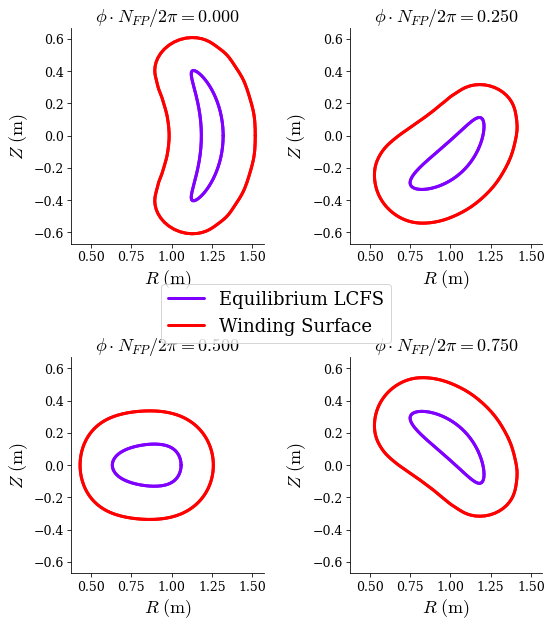

In [4]:
plt.rcParams.update({"font.size": 18})
fig, ax = plot_comparison(
    eqs=[eq, surf],
    labels=["Equilibrium LCFS", "Winding Surface"],
    phi=np.linspace(0, 2 * np.pi / eq.NFP, 4, endpoint=False),
    theta=0,
    rho=1.0,
    lw=[3],
    legend_kw={"loc": "center"},
)
if save_stuff:
    plt.savefig("figures/eq_and_surf_bdry.png")

In [5]:
# run regcoil
field = FourierCurrentPotentialField.from_surface(surf, sym_Phi="sin")
field.change_Phi_resolution(M=12, N=12)
source_grid = LinearGrid(M=45, N=45, NFP=eq.NFP)
eval_grid = LinearGrid(M=20, N=20, NFP=eq.NFP, sym=True)
field_modular = field

# scan_lambda_regularizations=np.logspace(-18,-6,20)

field, data = solve_regularized_surface_current(
    field,
    eq,
    lambda_regularization=1e-20,
    vacuum=True,
    eval_grid=eval_grid,
    source_grid=source_grid,
    regularization_type="regcoil",
    chunk_size=15,
)
field = field[0]  # it returns a list, take first element
field_modular = field
result_modular = data


field_helical = field.copy()
field_helical, result_helical = solve_regularized_surface_current(
    field_helical,
    eq,
    current_helicity=(1 * eq.NFP, -1),
    lambda_regularization=1e-20,
    vacuum=True,
    eval_grid=eval_grid,
    source_grid=source_grid,
    regularization_type="regcoil",
    chunk_size=15,
)
field_helical = field_helical[0]

##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-20
##########################################################
chi^2 B = 6.06303e-10
min Bnormal = 5.86129e-12 (T)
Max Bnormal = 4.87289e-07 (T)
Avg Bnormal = 5.68123e-08 (T)
min Bnormal = 5.65742e-12 (unitless)
Max Bnormal = 4.70340e-07 (unitless)
Avg Bnormal = 5.48363e-08 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-20
##########################################################
chi^2 B = 8.39405e-10
min Bnormal = 2.34279e-11 (T)
Max Bnormal = 4.46781e-07 (T)
Avg Bnormal = 7.37162e-08 (T)
min Bnormal = 2.26130e-11 (unitless)
Max Bnormal = 4.31241e-07 (unitless)
Avg Bnormal = 7.11522e-08 (unitless)


({'fig_Phi': <Figure size 864.648x576.432 with 2 Axes>,
  'fig_Bn': <Figure size 864.648x576.432 with 2 Axes>,
  'fig_K': <Figure size 864.648x576.432 with 2 Axes>},
 {'ax_Phi': <Axes: title={'center': '$\\lambda =$ 1.00000e-20 index = 0'}, xlabel='$\\zeta$', ylabel='$\\theta$'>,
  'ax_Bn': <Axes: title={'center': '$\\lambda =$ 1.00000e-20 index = 0'}, xlabel='$\\zeta$', ylabel='$\\theta$'>,
  'ax_K': <Axes: title={'center': '$\\lambda =$ 1.00000e-20 index = 0'}, xlabel='$\\zeta$', ylabel='$\\theta$'>})

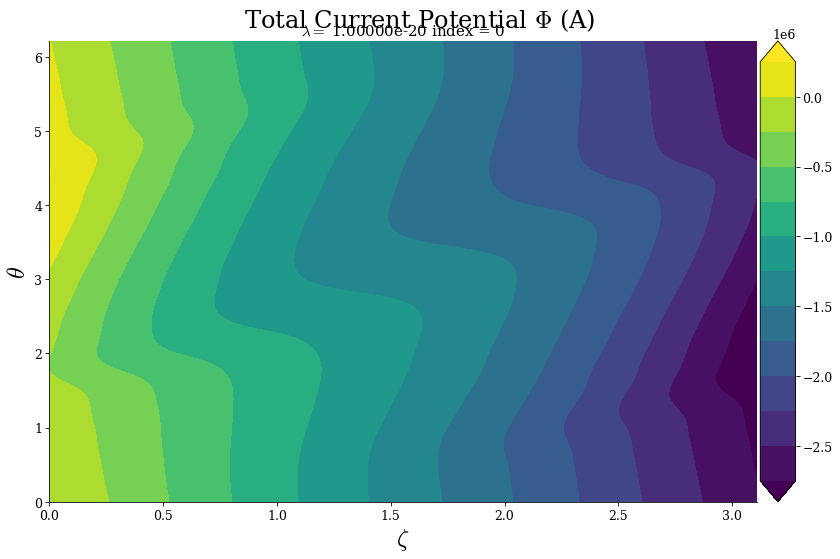

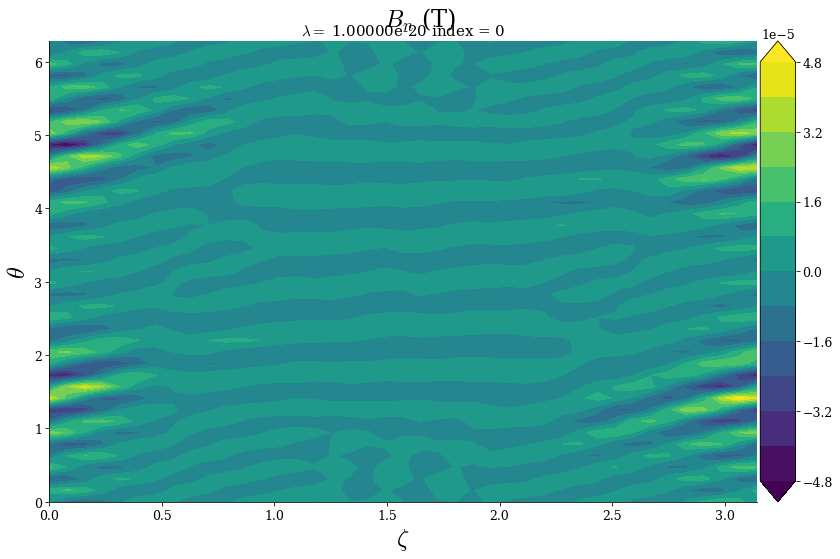

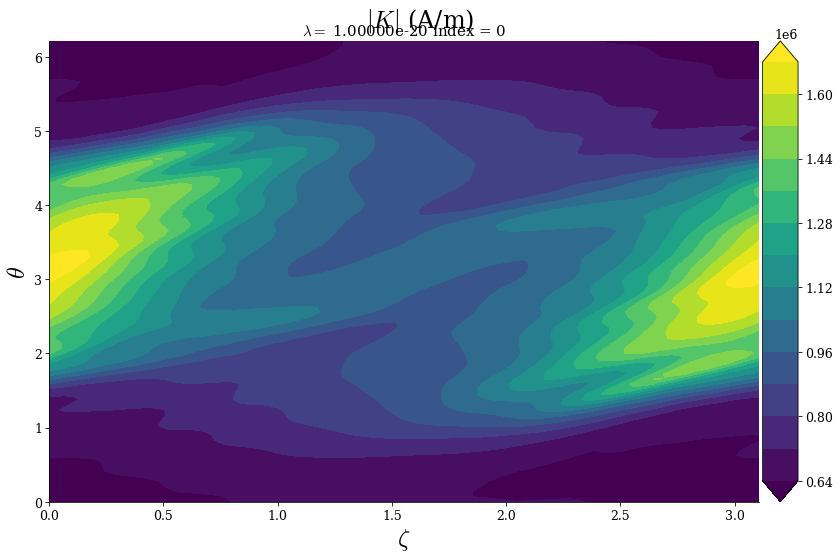

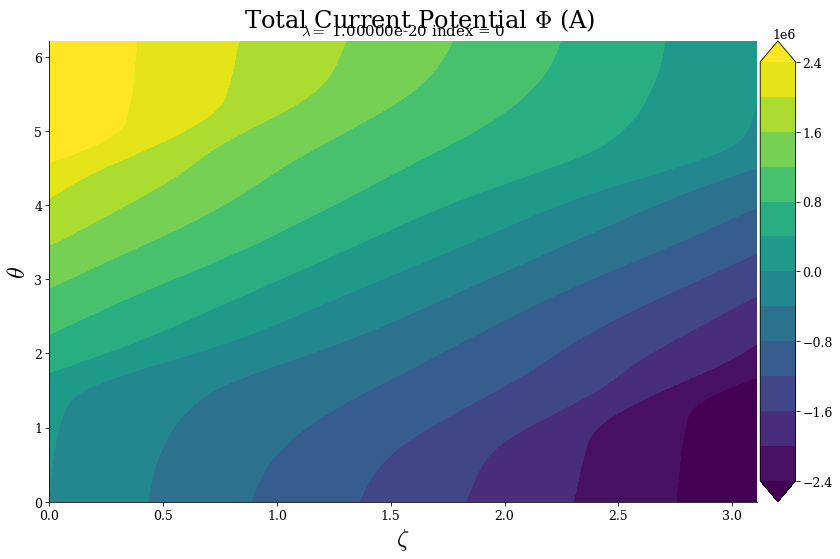

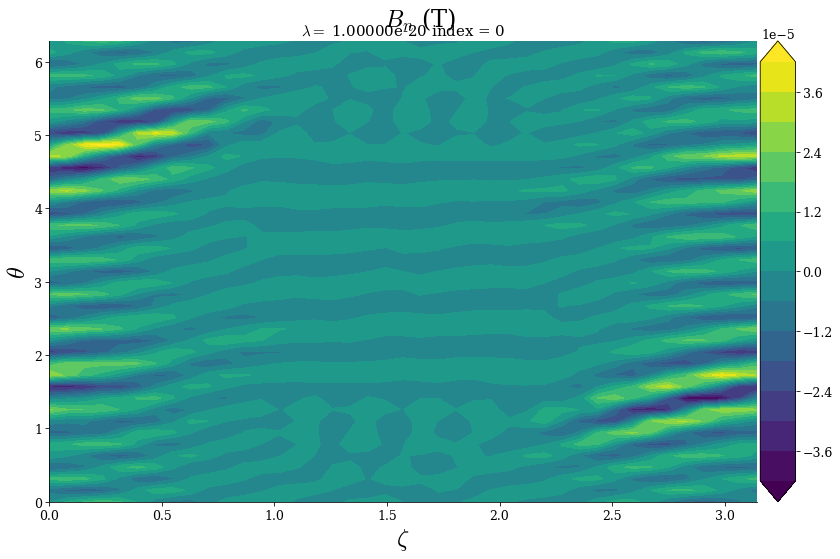

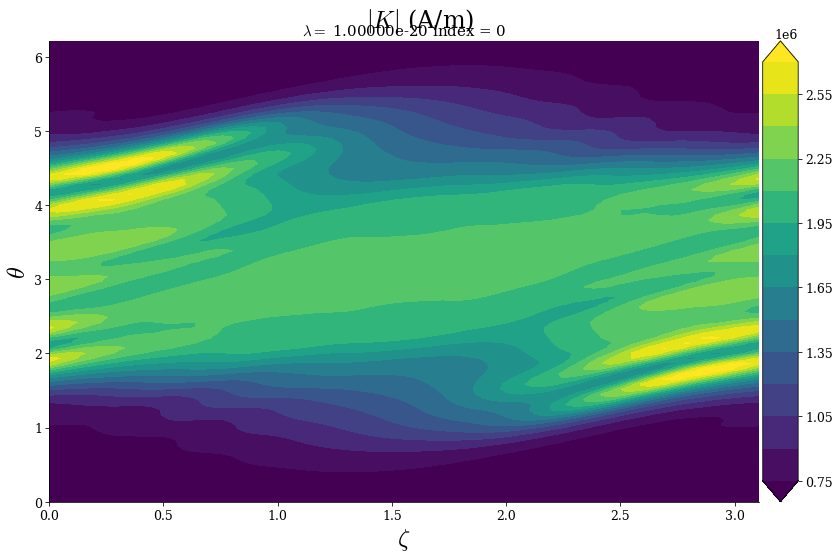

In [6]:
plot_regcoil_outputs(field_modular, data, eq, vacuum=True)
plot_regcoil_outputs(field_helical, result_helical, eq, vacuum=True)

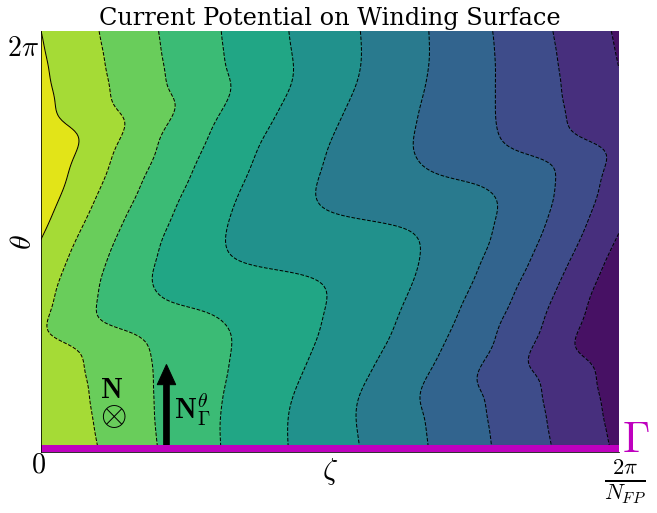

In [7]:
grid = LinearGrid(NFP=eq.NFP, M=80, N=80)
p = field.compute("Phi", grid=grid)["Phi"]
p = p.reshape(grid.num_theta, grid.num_zeta)
plt.rcParams.update({"font.size": 36})
plt.figure(figsize=(10, 8))
plt.contourf(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=12,
)
# plt.colorbar()
plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=12,
    colors=["k"],
)

plt.xticks([])
plt.yticks([])

plt.xlabel(r"$\zeta$", color="k")
plt.ylabel(r"$\theta$", color="k")

plt.arrow(0.68, 0, 0, 1, head_width=0.1, head_length=0.3, color="k", width=0.03)
plt.text(0.72, 0.5, r"$\mathbf{N}_{\Gamma}^{\theta}$", size=28)
plt.text(-0.05, -0.3, r"$0$", size=28, color="k")
plt.text(2 * np.pi / eq.NFP - 0.1, -0.5, r"$\frac{2\pi}{N_{FP}}$", size=32, color="k")
plt.text(-0.18, 2 * np.pi - 0.4, r"$2\pi$", size=28, color="k")


plt.text(0.32, 0.4, r"$\otimes$", size=34)
plt.text(0.32, 0.8, r"$\mathbf{N}$", size=28)

plt.axhline(0, c="m", linewidth=15)
plt.text(2 * np.pi / eq.NFP, 0.0, r"$\Gamma$", size=44, c="m")


plt.title("Current Potential on Winding Surface", color="k", size=24)
if save_stuff:
    plt.savefig("figures/poloidal_current_derivation.png")

# Figure for the surface integral stuff

/Users/dpanici/Research/DESC/desc/utils.py:520: FutureWarning: argument zeta has been renamed to phi, zeta will be removed in a future release
  warnings.warn(


(-0.5, 0.5)

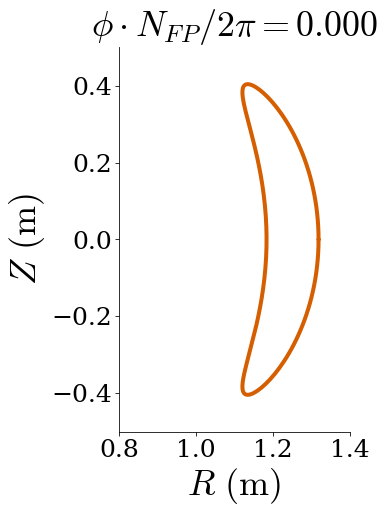

In [8]:
import plotly.graph_objects as go

plot_surfaces(eq, rho=1.0, zeta=0.0, theta=0, rho_lw=1, lcfs_lw=4, figsize=(8, 8))
plt.xlim([0.8, 1.4])
plt.ylim([-0.5, 0.5])

# difference btwn $\nabla(\theta)$ and $n_{\gamma}^{\theta}$

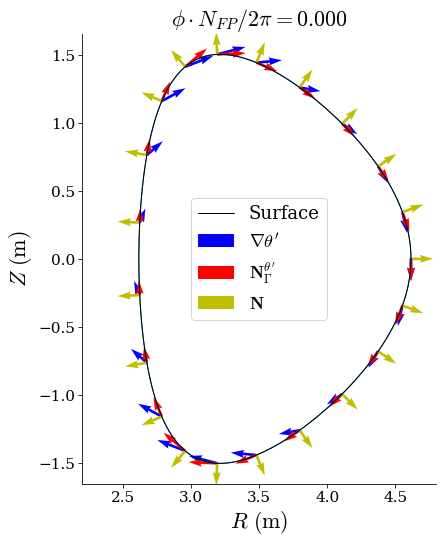

In [9]:
scale = 14

plt.rcParams.update({"font.size": 22})
eq_axisym = get("DSHAPE")
eq_axisym.set_initial_guess(eq_axisym.surface)
data = eq_axisym.compute(
    ["R", "Z", "e^theta", "n_rho"],
    grid=LinearGrid(M=10, sym=False, zeta=0, rho=np.array(1.0)),
)

fig, ax = plot_surfaces(
    eq_axisym,
    theta=0,
    rho=np.array(1.0),
    figsize=(8, 8),
    label="Surface",
    lcfs_color="k",
)
ax[0].quiver(
    data["R"],
    data["Z"],
    data["e^theta"][:, 0],
    data["e^theta"][:, 2],
    label=r"$\nabla\theta'$",
    scale=scale,
    color="b",
)
n_th = (
    data["e^theta"]
    - (np.sum(data["e^theta"] * data["n_rho"], axis=1) * data["n_rho"].T).T
)
# n_th =( n_th.T / np.linalg.norm(n_th,axis=-1)).T
ax[0].quiver(
    data["R"],
    data["Z"],
    n_th[:, 0],
    n_th[:, 2],
    color="r",
    label=r"$\mathbf{N}_{\Gamma}^{\theta'}$",
    scale=scale,
)
ax[0].quiver(
    data["R"],
    data["Z"],
    data["n_rho"][:, 0],
    data["n_rho"][:, 2],
    color="y",
    label=r"$\mathbf{N}$",
    scale=scale + 2,
)
ax[0].set_xlim([2.2, 4.8])
ax[0].legend(fontsize=18)
fig = plt.gcf()
if save_stuff:
    fig.savefig("figures/diagram_grad_theta_n_theta.png")

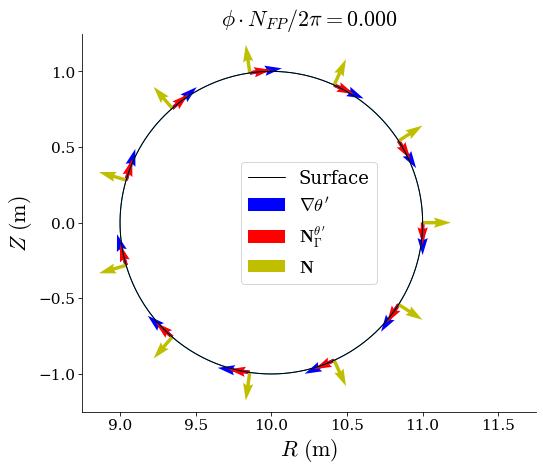

In [10]:
# scale = 10

eq_axisym = Equilibrium()
data = eq_axisym.compute(
    ["R", "Z", "e^theta", "n_rho"],
    grid=LinearGrid(M=5, sym=False, zeta=0, rho=np.array(1.0)),
)

fig, ax = plot_surfaces(
    eq_axisym,
    theta=0,
    rho=np.array(1.0),
    figsize=(8, 8),
    label="Surface",
    lcfs_color="k",
)
ax[0].quiver(
    data["R"],
    data["Z"],
    data["e^theta"][:, 0],
    data["e^theta"][:, 2],
    label=r"$\nabla\theta'$",
    scale=scale,
    color="b",
)
n_th = (
    data["e^theta"]
    - (np.sum(data["e^theta"] * data["n_rho"], axis=1) * data["n_rho"].T).T
)
n_th = n_th * 2 / 3
# n_th =( n_th.T / np.linalg.norm(n_th,axis=-1)).T
ax[0].quiver(
    data["R"],
    data["Z"],
    n_th[:, 0],
    n_th[:, 2],
    color="r",
    label=r"$\mathbf{N}_{\Gamma}^{\theta'}$",
    scale=scale,
)
ax[0].quiver(
    data["R"],
    data["Z"],
    data["n_rho"][:, 0],
    data["n_rho"][:, 2],
    color="y",
    label=r"$\mathbf{N}$",
    scale=scale + 2,
)
ax[0].set_xlim([8.75, 11.75])
ax[0].set_ylim([-1.25, 1.25])

ax[0].legend(fontsize=18)
fig = plt.gcf()
if save_stuff:
    fig.savefig("figures/diagram_grad_theta_n_theta_circular_torus.png")

# figure showing different current helicity and I,G signs

In [11]:
%pdb

Automatic pdb calling has been turned ON


In [12]:
%pdb

Automatic pdb calling has been turned OFF


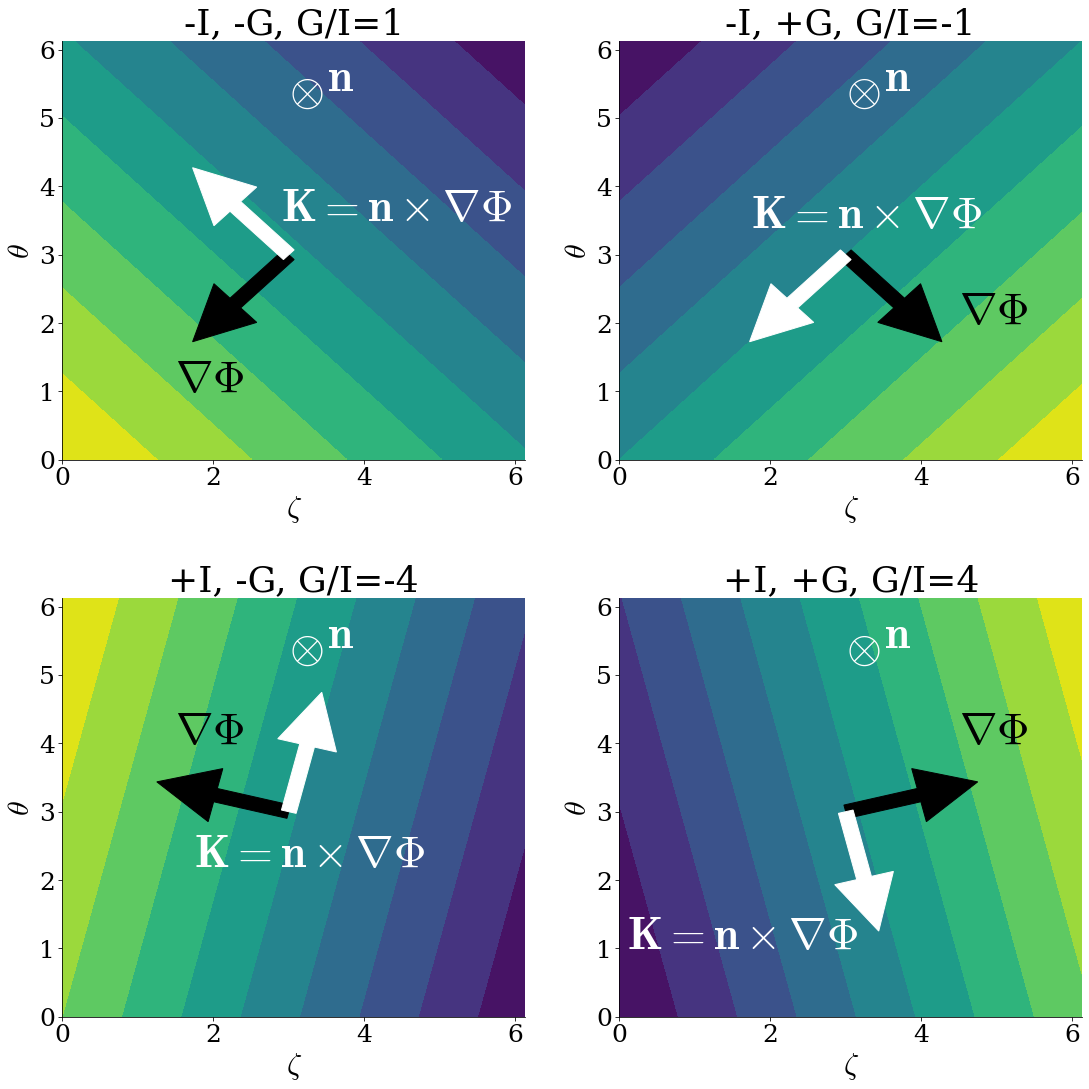

In [13]:
# import warnings


plt.rcParams.update({"font.size": 36})
plt.subplots(2, 2, figsize=(16, 16))
labels = {-1: "-", 1: "+"}

grid = LinearGrid(M=20, N=20, NFP=1)
i = 1

for I_sign, G_sign in zip([-1, -1, 1, 1], [-1, 1, -4, 4]):
    f = FourierCurrentPotentialField(I=I_sign, G=G_sign)
    p = f.compute("Phi", grid=grid)["Phi"].reshape(grid.num_theta, grid.num_zeta)
    plotnum = int(f"22{i}")
    plt.subplot(plotnum)
    i += 1
    plt.contourf(
        grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
        grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
        p,
        levels=10,
    )
    # plt.contour(grid.nodes[:,2].reshape(grid.num_theta, grid.num_zeta),grid.nodes[:,1].reshape(grid.num_theta, grid.num_zeta),p,
    #         levels=20,linewidths=5,vmin=np.min(p),vmax=np.max(p))
    # if i==3:
    # plt.colorbar()
    plt.xlabel(r"$\zeta$", color="k")
    plt.ylabel(r"$\theta$", color="k")
    plt.title(
        f"{labels[I_sign]}I, {labels[round(np.sign(G_sign))]}G, G/I={round(G_sign/I_sign)}",
        size=36,
    )

    # nabla Phi text
    dtheta = I_sign
    dzeta = G_sign
    norm = np.sqrt(I_sign**2 + G_sign**2)
    dtheta = dtheta / norm
    dzeta = dzeta / norm
    plt.arrow(
        3, 3, dzeta, dtheta, head_width=0.8, head_length=0.8, color="k", width=0.2
    )
    if I_sign == 1 and round(np.sign(G_sign)) == 1:
        plt.text(
            2.5 + 2 * np.sign(G_sign),
            2.5 + 1.5 * I_sign,
            r"$\mathbf{\nabla \Phi}$",
            size=45,
        )
    elif I_sign == -1 and round(np.sign(G_sign)) == -1:
        plt.text(
            2.5 + 1 * np.sign(G_sign),
            2.5 + 1.5 * I_sign,
            r"$\mathbf{\nabla \Phi}$",
            size=45,
        )
    else:
        plt.text(
            3 + 1.5 * np.sign(G_sign),
            3 + 1 * I_sign,
            r"$\mathbf{\nabla \Phi}$",
            size=45,
        )
    # N vector text
    plt.text(3, 5.2, r"$\otimes$", size=45, color="w")
    plt.text(3.5, 5.4, r"$\mathbf{n}$", size=45, color="w")
    # K Vector text
    dzeta = I_sign
    dtheta = -G_sign
    norm = np.sqrt(I_sign**2 + G_sign**2)
    dtheta = dtheta / norm
    dzeta = dzeta / norm
    curr_color = "w"
    plt.arrow(
        3,
        3,
        dzeta,
        dtheta,
        head_width=0.8,
        head_length=0.8,
        color=curr_color,
        width=0.2,
    )
    if np.sign(I_sign) == np.sign(G_sign):
        plt.text(
            1.5 - 1.4 * I_sign,
            3 - G_sign / 2,
            r"$\mathbf{K} = \mathbf{n} \times \nabla \Phi$",
            size=45,
            color=curr_color,
        )
    else:
        plt.text(
            1.75,
            2.8 + 0.6 * np.sign(G_sign),
            r"$\mathbf{K} = \mathbf{n} \times \nabla \Phi$",
            size=45,
            color=curr_color,
        )
if save_stuff:
    plt.savefig("figures/current_helicities_2d.png")

In [14]:
field_helical.G

-5520202.284912866

# helical coil contours figure

/var/folders/_2/0q3by2q141q8gwknwp9q87lm0000gp/T/ipykernel_53715/1212549573.py:32: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(


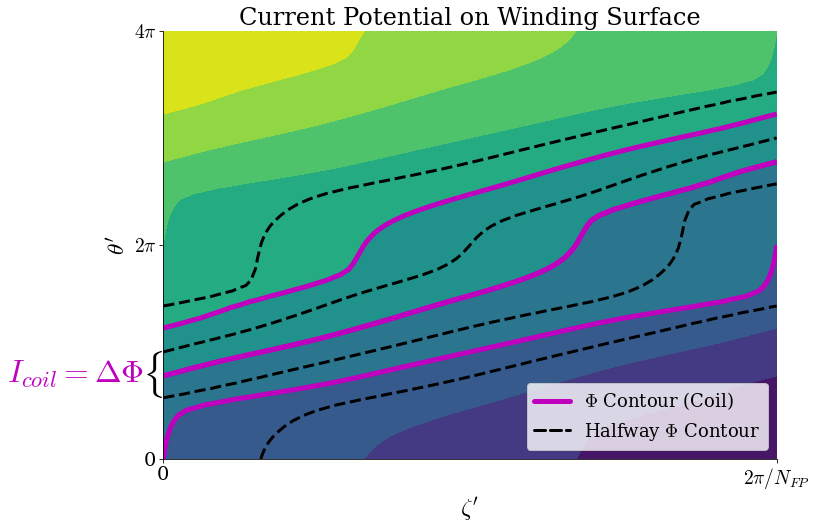

In [15]:
field = field_helical

npts = 80
thetas = np.linspace(0, 2 * np.pi * 2, npts)
zetas = np.linspace(0, 2 * np.pi / eq.NFP, npts)
thetas, zetas = np.meshgrid(thetas, zetas, indexing="xy")
thetas = thetas.flatten("F")
zetas = zetas.flatten("F")

from desc.grid import Grid

grid = Grid(np.vstack([np.ones_like(zetas), thetas, zetas]).T)
p = field.compute("Phi", grid=grid)["Phi"]
p = p.reshape(grid.num_theta, grid.num_zeta)
plt.rcParams.update({"font.size": 28})
plt.figure(figsize=(12, 8))
levels = np.flip(np.linspace(2 * field.I, field.G / eq.NFP, 10))
# levels = np.flip(levels)
plt.contourf(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=levels,
)
# plt.colorbar()

# coil contours
top_ind = 3
bot_ind = 6
ind = 4
coilcolor = "m"
plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=[levels[ind]],
    colors=[coilcolor],
    linewidths=[5],
    labels=["Coil"],
)
plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=levels[top_ind:bot_ind],
    colors=[coilcolor],
    linewidths=[5],
    linestyles="solid",
)
# halfway contours
levels_half = levels + 0.5 * (levels[1] - levels[0])

plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=levels_half[top_ind - 1 : bot_ind],
    colors=["k"],
    linewidths=[3],
    linestyles="dashed",
)


locs, labels = plt.yticks()
xlocs, xlabels = plt.xticks()

plt.yticks(np.append(locs[0], [2 * np.pi, 4 * np.pi]), ["0", r"$2\pi$", r"$4\pi$"])
plt.xticks(np.append(xlocs[0], 2 * np.pi / eq.NFP), ["0", r"$2\pi/{N_{FP}}$"])


plt.xlabel(r"$\zeta'$", color="k")
plt.ylabel(r"$\theta'$", color="k")

plt.plot([1, 1], [1, 1], f"{coilcolor}-", label=r"$\Phi$ Contour (Coil)", lw=5)
plt.plot([1, 1], [1, 1], "k--", label=r"Halfway $\Phi$ Contour", lw=3)
plt.legend(loc="lower right", fontsize=18)
plt.annotate(r"$\{$", fontsize=40, xy=(-0.035, 0.165), xycoords="axes fraction")
# plt.axvline(-0.01,c="m",linewidth=15,ymax=0.18)
plt.text(-0.80, 2.25, r"$I_{coil}=\Delta \Phi$", size=32, c=coilcolor)


plt.title("Current Potential on Winding Surface", color="k", size=24)
if save_stuff:
    plt.savefig("figures/coil_contours_helical.png")

# modular coil contours figure

In [16]:
field.G

-5520202.284912866

/var/folders/_2/0q3by2q141q8gwknwp9q87lm0000gp/T/ipykernel_53715/2094055919.py:39: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(


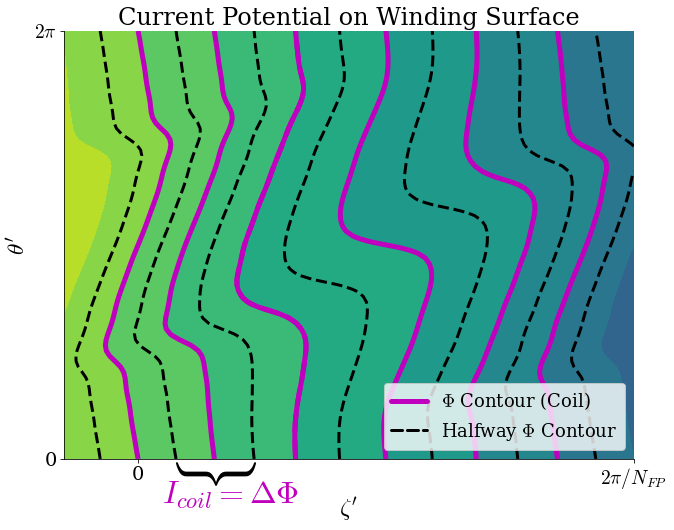

In [17]:
field = field_modular

npts = 80
thetas = np.linspace(0, 2 * np.pi, npts)
zetas = np.linspace(-0.15 * 2 * np.pi / eq.NFP, 2 * np.pi / eq.NFP, npts)
thetas, zetas = np.meshgrid(thetas, zetas, indexing="xy")
thetas = thetas.flatten("F")
zetas = zetas.flatten("F")
grid = Grid(np.vstack([np.ones_like(zetas), thetas, zetas]).T)

Ncoils = 6

p = field.compute("Phi", grid=grid)["Phi"]
p = p.reshape(grid.num_theta, grid.num_zeta)
plt.rcParams.update({"font.size": 28})
plt.figure(figsize=(10, 8))
levels = np.flip(np.linspace(-field.G / eq.NFP * 0.1, 1.1 * field.G / eq.NFP, Ncoils))
levels_to_plot_contourf = np.flip(
    np.arange(
        -3 * field.G / eq.NFP / Ncoils, 2 * field.G / eq.NFP, field.G / eq.NFP / Ncoils
    )
)
levels_to_plot_coils = np.flip(
    np.arange(-1, 1.01 * field.G / eq.NFP, field.G / eq.NFP / Ncoils)
)

plt.contourf(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=levels_to_plot_contourf,
)
# plt.colorbar()
# coil contours
top_ind = 1
bot_ind = None
ind = 4
coilcolor = "m"
plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=[levels_to_plot_coils[ind]],
    colors=[coilcolor],
    linewidths=[5],
    labels=["Coil"],
)
plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=levels_to_plot_coils[top_ind:bot_ind],
    colors=[coilcolor],
    linewidths=[5],
    linestyles="solid",
)
# halfway contours
levels_half = levels_to_plot_coils + 0.5 * (
    levels_to_plot_coils[1] - levels_to_plot_coils[0]
)

plt.contour(
    grid.nodes[:, 2].reshape(grid.num_theta, grid.num_zeta),
    grid.nodes[:, 1].reshape(grid.num_theta, grid.num_zeta),
    p,
    levels=levels_half[top_ind - 1 : bot_ind],
    colors=["k"],
    linewidths=[3],
    linestyles="dashed",
)


locs, labels = plt.yticks()
xlocs, xlabels = plt.xticks()

plt.yticks(np.append(locs[0], np.max(grid.nodes[:, 1])), ["0", r"$2\pi$"])
plt.xticks(
    np.append(np.array([0.0]), np.max(grid.nodes[:, 2])), ["0", r"$2\pi/{N_{FP}}$"]
)


plt.xlabel(r"$\zeta'$", color="k")
plt.ylabel(r"$\theta'$", color="k")

plt.plot([1, 1], [1, 1], f"{coilcolor}-", label=r"$\Phi$ Contour (Coil)", lw=5)
plt.plot([1, 1], [1, 1], "k--", label=r"Halfway $\Phi$ Contour", lw=3)
plt.legend(loc="lower right", fontsize=18)
plt.annotate(
    r"$\{$", fontsize=65, xy=(0.195, -0.039), xycoords="axes fraction", rotation=90
)
# plt.axvline(-0.01,c="m",linewidth=15,ymax=0.18)
plt.text(0.15, -0.65, r"$I_{coil}=\Delta \Phi$", size=32, c=coilcolor)

# plt.text(-1.45,2.25,r"$I_{coil}=\Delta \Phi$",size=32,c="w")


plt.title("Current Potential on Winding Surface", color="k", size=24)
if save_stuff:
    plt.savefig("figures/coil_contours_modular.png")

# Modular coil figure

In [18]:
field = field_modular
coils_modular = field.to_CoilSet(24, step=2)

from desc.plotting import *

figsize = (10, 10)
fig = plot_3d(
    eq.surface,
    "B*n",
    field=coils_modular,
    figsize=figsize,
    zeroline=False,
    showgrid=False,
)
fig = plot_coils(coils_modular, fig=fig, figsize=figsize)
fig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
        xaxis_title=" ",
        yaxis_title=" ",
        zaxis_title=" ",
    ),
)
fig.show()
if save_stuff:
    fig.write_image("figures/modular_coils.png")

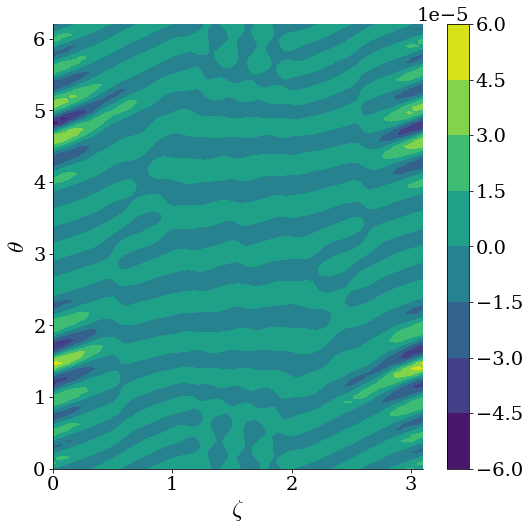

In [19]:
# Bn from surf current
grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
eval_grid = LinearGrid(M=40, N=40, NFP=eq.NFP)
Bn, _ = field.compute_Bnormal(eq.surface, eval_grid=eval_grid, source_grid=grid)

th = eval_grid.nodes[:, 1].reshape((eval_grid.num_theta, eval_grid.num_zeta))
ze = eval_grid.nodes[:, 2].reshape((eval_grid.num_theta, eval_grid.num_zeta))

plt.figure(figsize=(8, 8))
plt.contourf(ze, th, Bn.reshape((eval_grid.num_theta, eval_grid.num_zeta)))
plt.colorbar()
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")


if save_stuff:
    plt.savefig("figures/Bn_surf_current_modular.png")

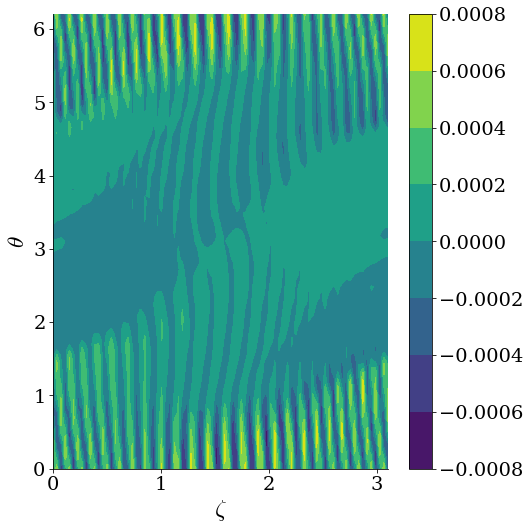

In [20]:
# Bn from coils
# grid = LinearGrid(M=80, N=80,NFP=eq.NFP)
eval_grid = LinearGrid(M=40, N=40, NFP=eq.NFP)
Bn, _ = coils_modular.compute_Bnormal(eq.surface, eval_grid=eval_grid)

th = eval_grid.nodes[:, 1].reshape((eval_grid.num_theta, eval_grid.num_zeta))
ze = eval_grid.nodes[:, 2].reshape((eval_grid.num_theta, eval_grid.num_zeta))

plt.figure(figsize=(8, 8))
plt.contourf(ze, th, Bn.reshape((eval_grid.num_theta, eval_grid.num_zeta)))
plt.colorbar()
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")


if save_stuff:
    plt.savefig("figures/Bn_coils_modular.png")

# Helical coil figure

In [21]:
field = field_helical
coils_helical = field.to_CoilSet(16)

In [22]:
from desc.plotting import *

figsize = (10, 10)
fig = plot_3d(
    eq.surface,
    "B*n",
    field=coils_helical,
    figsize=figsize,
    zeroline=False,
    showgrid=False,
)

# colors=["black","cyan","darkmagenta"]*2
# for coi,col in zip(coils_helical,colors):
#     fig=plot_coils(coi,fig=fig,color=col,figsize=figsize)
fig = plot_coils(coils_helical, fig=fig, figsize=figsize)
fig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
        xaxis_title=" ",
        yaxis_title=" ",
        zaxis_title=" ",
    ),
)
fig.show()
if save_stuff:
    fig.write_image("figures/helical_coils.png")

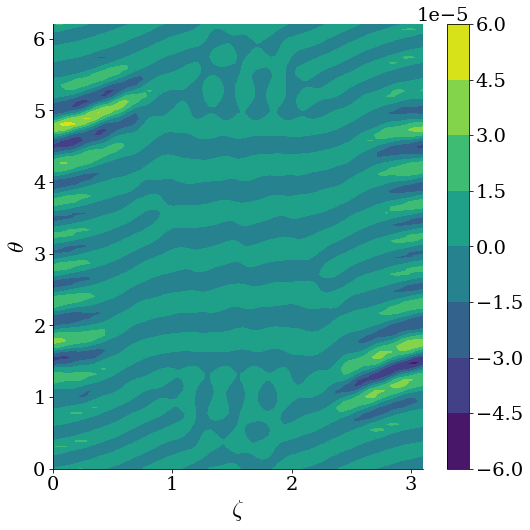

In [23]:
# Bn from surf current
grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
eval_grid = LinearGrid(M=40, N=40, NFP=eq.NFP)
Bn, _ = field.compute_Bnormal(eq.surface, eval_grid=eval_grid, source_grid=grid)

th = eval_grid.nodes[:, 1].reshape((eval_grid.num_theta, eval_grid.num_zeta))
ze = eval_grid.nodes[:, 2].reshape((eval_grid.num_theta, eval_grid.num_zeta))

plt.figure(figsize=(8, 8))
plt.contourf(ze, th, Bn.reshape((eval_grid.num_theta, eval_grid.num_zeta)))
plt.colorbar()
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")


if save_stuff:
    plt.savefig("figures/Bn_surf_current_helical.png")

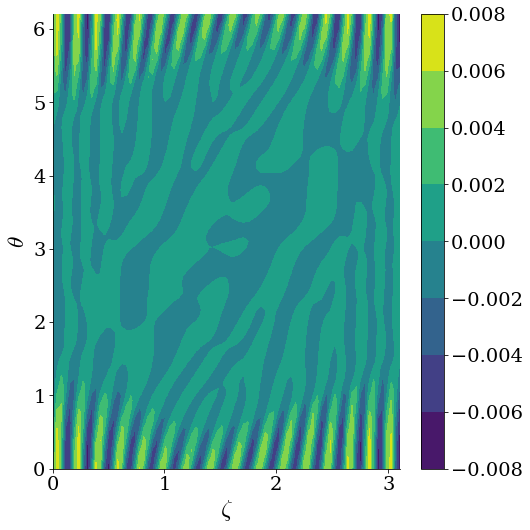

In [24]:
# Bn from helical coils
# grid = LinearGrid(M=80, N=80,NFP=eq.NFP)
eval_grid = LinearGrid(M=40, N=40, NFP=eq.NFP)
Bn, _ = coils_helical.compute_Bnormal(eq.surface, eval_grid=eval_grid)

th = eval_grid.nodes[:, 1].reshape((eval_grid.num_theta, eval_grid.num_zeta))
ze = eval_grid.nodes[:, 2].reshape((eval_grid.num_theta, eval_grid.num_zeta))

plt.figure(figsize=(8, 8))
plt.contourf(ze, th, Bn.reshape((eval_grid.num_theta, eval_grid.num_zeta)))
plt.colorbar()
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")


if save_stuff:
    plt.savefig("figures/Bn_coils_helical.png")

Text(0.5, 1.0, 'Phi')

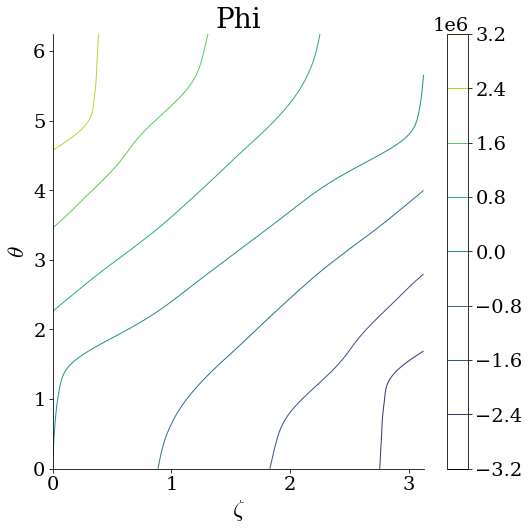

In [25]:
# Bn from surf current
grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
eval_grid = grid
phi = field.compute("Phi", grid=grid)["Phi"]
th = eval_grid.nodes[:, 1].reshape((eval_grid.num_theta, eval_grid.num_zeta))
ze = eval_grid.nodes[:, 2].reshape((eval_grid.num_theta, eval_grid.num_zeta))

plt.figure(figsize=(8, 8))
plt.contour(ze, th, phi.reshape((eval_grid.num_theta, eval_grid.num_zeta)))
plt.colorbar()
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")
plt.title("Phi")

# modular field trace

Bn calc took 1.596e+00 seconds
normalized average <Bn> = 0.00016501284751387627


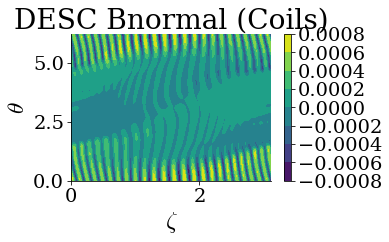

In [26]:
import time

grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
t1 = time.time()
Bn, _ = coils_modular.compute_Bnormal(eq.surface, eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(
    grid.nodes[grid.unique_zeta_idx, 2],
    grid.nodes[grid.unique_theta_idx, 1],
    Bn.reshape((grid.num_zeta, grid.num_theta)).T,
)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

print(
    f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}"
)

Bn calc took 6.334e-01 seconds


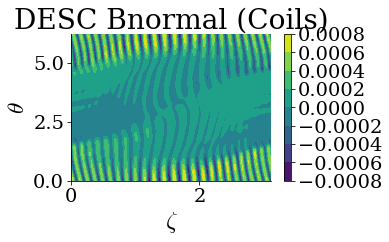

In [27]:
# fitting with a Fourier series will make the magnetic field computation more computationally efficient
cset = coils_modular.to_FourierXYZ(N=30)
t1 = time.time()
Bn, _ = cset.compute_Bnormal(eq.surface, eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(
    grid.nodes[grid.unique_zeta_idx, 2],
    grid.nodes[grid.unique_theta_idx, 1],
    Bn.reshape((grid.num_zeta, grid.num_theta)).T,
)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

(<Figure size 432.324x432.324 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

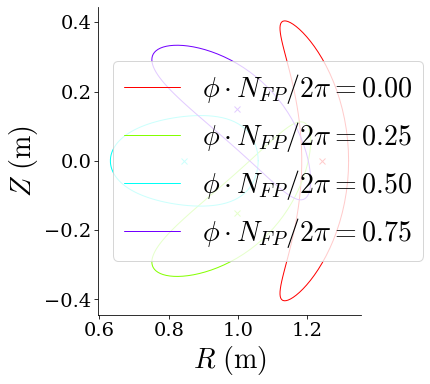

In [28]:
plot_boundary(eq)

In [29]:
# Field line integration (on a CPU this can take a few minutes)
from desc.magnetic_fields import field_line_integrate

rho = np.linspace(0, 1, 10, endpoint=True)

ntransit = 200
r0 = eq.compute("R", grid=LinearGrid(rho=rho, M=0, N=0, NFP=eq.NFP))["R"]
# r0 = np.linspace(1.16,1.25,20)
phis = np.arange(0, ntransit * 2 * np.pi + 1, 2 * np.pi)
t1 = time.time()
fieldR, fieldZ = field_line_integrate(
    r0=r0,
    z0=np.zeros_like(r0),
    phis=phis,
    field=cset,
    bounds_R=(0.5, 1.5),
)
print(f"field line integration took {time.time()-t1:1.3e} seconds")
# old field line integration took 6.373e+02 seconds

field line integration took 1.703e+02 seconds


/Users/dpanici/Research/DESC/desc/utils.py:520: FutureWarning:

argument zeta has been renamed to phi, zeta will be removed in a future release



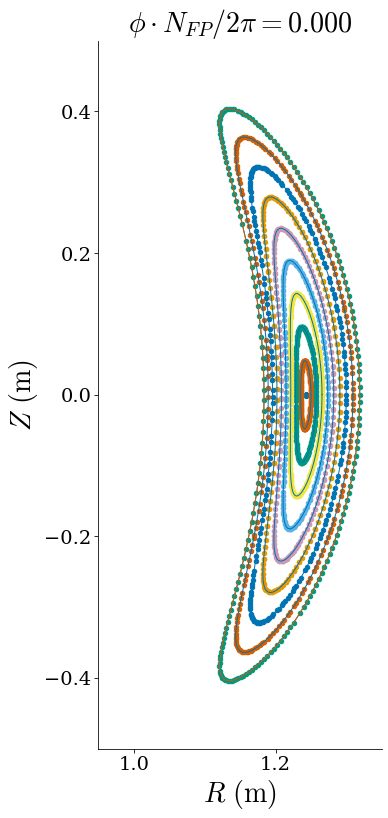

In [30]:
import matplotlib.pyplot as plt

fig, ax = plot_surfaces(eq, zeta=np.array(0.0), theta=0, figsize=(12, 12), rho=rho)
for i in range(fieldR.shape[1]):
    ax[0].scatter(fieldR[:, i], fieldZ[:, i], s=20)

plt.xlim([0.95, 1.35])
plt.ylim([-0.5, 0.5])
if save_stuff:
    plt.savefig("figures/field_trace_modular.png")

# helical coil field trace

Bn calc took 5.855e-01 seconds
normalized average <Bn> = 0.0011641964888784047


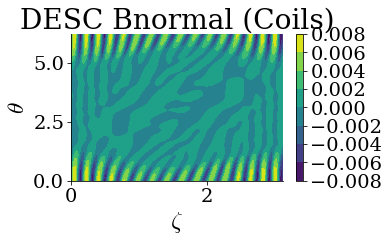

In [31]:
import time

grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
t1 = time.time()
Bn, _ = coils_helical.compute_Bnormal(eq.surface, eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(
    grid.nodes[grid.unique_zeta_idx, 2],
    grid.nodes[grid.unique_theta_idx, 1],
    Bn.reshape((grid.num_zeta, grid.num_theta)).T,
)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

print(
    f"normalized average <Bn> = {np.mean(np.abs(Bn) / eq.compute('|B|',grid=grid)['|B|'])}"
)

Bn calc took 2.609e-01 seconds


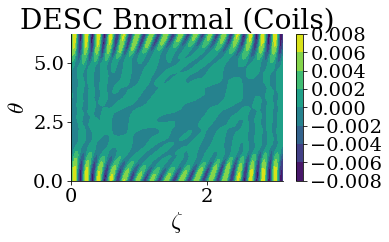

In [32]:
# fitting with a Fourier series will make the magnetic field computation more computationally efficient
cset = coils_helical.to_FourierXYZ(N=40)
t1 = time.time()
Bn, _ = cset.compute_Bnormal(eq.surface, eval_grid=grid)
print(f"Bn calc took {time.time()-t1:1.3e} seconds")
plt.figure()
plt.contourf(
    grid.nodes[grid.unique_zeta_idx, 2],
    grid.nodes[grid.unique_theta_idx, 1],
    Bn.reshape((grid.num_zeta, grid.num_theta)).T,
)
plt.title("DESC Bnormal (Coils)")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")

plt.colorbar()

In [33]:
# Field line integration (on a CPU this can take a few minutes)
from desc.magnetic_fields import field_line_integrate

rho = np.linspace(0, 1, 10, endpoint=True)
ntransit = 200
r0 = eq.compute("R", grid=LinearGrid(rho=rho, M=0, N=0, NFP=eq.NFP))["R"]
phis = np.arange(0, ntransit * 2 * np.pi + 1, 2 * np.pi)
t1 = time.time()
fieldR, fieldZ = field_line_integrate(
    r0=r0,
    z0=np.zeros_like(r0),
    phis=phis,
    field=cset,
    # bounds_R = (0.3,1.8),
    # bounds_Z=(-1,1)
)
print(f"field line integration took {time.time()-t1:1.3e} seconds")

field line integration took 8.838e+01 seconds


/Users/dpanici/Research/DESC/desc/utils.py:520: FutureWarning:

argument zeta has been renamed to phi, zeta will be removed in a future release



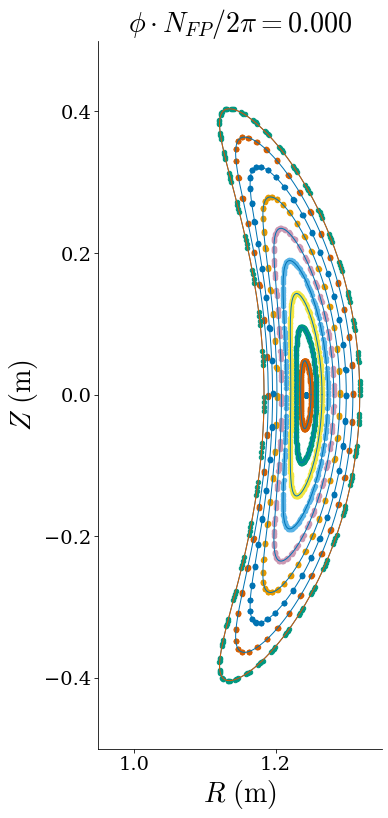

In [34]:
fig, ax = plot_surfaces(eq, zeta=np.array(0.0), theta=0, figsize=(12, 12), rho=rho)
for i in range(fieldR.shape[1]):
    ax[0].scatter(fieldR[:, i], fieldZ[:, i], s=20)

plt.xlim([0.95, 1.35])
plt.ylim([-0.5, 0.5])
if save_stuff:
    plt.savefig("figures/field_trace_helical.png")

# Pareto Fronts for Bn from surface current for different helicities

In [35]:
import copy

# run regcoil
field = FourierCurrentPotentialField.from_surface(surf, sym_Phi="sin")
field.change_Phi_resolution(M=8, N=8)
source_grid = LinearGrid(M=30, N=30, NFP=eq.NFP)
eval_grid = LinearGrid(M=20, N=20, NFP=eq.NFP, sym=True)

scan_lambda_regularizations = np.concatenate(
    [np.array([0.0]), np.logspace(-20, -5, 15)]
)

helicities = np.arange(-10, 10, 1)
fields = []
results = []
for hel in helicities:
    field_helical = field.copy()
    p = 1 if hel != 0 else 0
    q = hel if hel != 0 else 1
    field_helical, result_helical = solve_regularized_surface_current(
        field_helical,
        eq,
        current_helicity=(q, p),
        lambda_regularization=scan_lambda_regularizations,
        vacuum=True,
        eval_grid=eval_grid,
        source_grid=source_grid,
        regularization_type="regcoil",
        verbose=0,
        chunk_size=15,
    )
    fields.append(copy.deepcopy(field_helical))
    results.append(copy.deepcopy(result_helical))

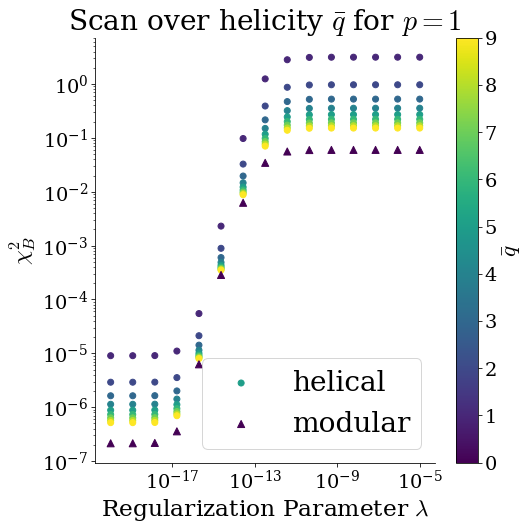

In [36]:
# make the plot
# this is with
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# plt.figure(figsize=(8, 8))
# for i in range(len(helicities)):
#     hel = helicities[i]
#     norm = Normalize(vmin=-10, vmax=0)
#     if hel > 0:
#         continue
#     if hel != 0:
#         if hel == -5:
#             plt.scatter(
#                 scan_lambda_regularizations,
#                 results[i]["chi^2_B"],
#                 c=np.ones_like(scan_lambda_regularizations) * helicities[i],
#                 norm=norm,
#                 label="helical",
#             )
#         else:
#             plt.scatter(
#                 scan_lambda_regularizations,
#                 results[i]["chi^2_B"],
#                 c=np.ones_like(scan_lambda_regularizations) * helicities[i],
#                 norm=norm,
#             )
#     else:
#         pass
#         # plt.scatter(scan_lambda_regularizations, results2[i]["chi^2_B"],c=np.ones_like(scan_lambda_regularizations) * helicities[i],norm=norm,marker="x",label="modular",s=30)
# plt.scatter(
#     scan_lambda_regularizations,
#     results[10]["chi^2_B"],
#     c=np.ones_like(scan_lambda_regularizations) * helicities[10],
#     norm=norm,
#     marker="^",
#     label="modular q=-1",
#     s=50,
# )
# plt.yscale("log")
# plt.xscale("log")
# plt.colorbar(label="q")
# plt.xlabel("Regularization Parameter")
# plt.ylabel("chi^2 B")
# plt.title("Scan over helicity q for p=1")

plt.figure(figsize=(8, 8))
for i in range(len(helicities)):
    hel = helicities[i]
    norm = Normalize(vmin=0, vmax=9)
    if hel < 0:
        continue
    if hel != 0:
        if hel == 5:
            plt.scatter(
                scan_lambda_regularizations,
                results[i]["chi^2_B"],
                c=np.ones_like(scan_lambda_regularizations) * helicities[i],
                norm=norm,
                label="helical",
            )
        else:
            plt.scatter(
                scan_lambda_regularizations,
                results[i]["chi^2_B"],
                c=np.ones_like(scan_lambda_regularizations) * helicities[i],
                norm=norm,
            )
    else:
        pass
        # plt.scatter(scan_lambda_regularizations, results2[i]["chi^2_B"],c=np.ones_like(scan_lambda_regularizations) * helicities[i],norm=norm,marker="x",label="modular",s=30)
plt.scatter(
    scan_lambda_regularizations,
    results[10]["chi^2_B"],
    c=np.ones_like(scan_lambda_regularizations) * helicities[10],
    norm=norm,
    marker="^",
    label="modular",
    s=50,
)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.colorbar(label=r"$\bar{q}$")
plt.xlabel(r"Regularization Parameter $\lambda$")
plt.ylabel(r"$\chi^2_B$")
plt.title(r"Scan over helicity $\bar{q}$ for $p=1$")
if save_stuff:
    plt.savefig("figures/helicity_scan_chi2B_pos_q.png")